In [1]:
import pandas as pd

In [2]:
dfpromo = pd.read_json('../data/portfolio.json', orient= 'records', lines = True)
dfppl = pd.read_json('../data/profile.json', orient= 'records', lines = True)
dfinfo = pd.read_json('../data/transcript.json', orient='records', lines=True)

In [3]:
# For ease of analysis, and better readability
##I'll shorten the `id` values for offers and peoples
##Shortening ids for offers to 6 characters, still keeps their uniqeness.
##For people, keeping first 8 characters is appropriate.

dfpromo['id'] = dfpromo['id'].str[:6]
dfppl['id'] = dfppl['id'].str[:8]
dfinfo['person_id'] = dfinfo['person'].str[:8]
del dfinfo['person']

Next, I'm going to clean the `value` column in the `dtinfo`:

## Transaction Data

In [4]:
dfinfo.sample(10, random_state = 2)

,event,value,time,person_id
69831,offer viewed,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},174,9a138d2b
285519,transaction,{'amount': 1.62},630,b16a6432
129664,offer completed,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,342,f216966e
241984,transaction,{'amount': 3.09},564,23211264
227854,transaction,{'amount': 1.13},528,f44b44b5
142285,offer viewed,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},378,cc5ba93c
92385,transaction,{'amount': 16.74},240,f8f12b89
178988,transaction,{'amount': 1.47},432,b787ee3c
72392,transaction,{'amount': 30.83},180,d62ec140
151195,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},408,1cfcd68c


In [5]:
dfinfo.iloc[129664]

event                                          offer completed
value        {'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...
time                                                       342
person_id                                             f216966e
Name: 129664, dtype: object

In [6]:
dfinfo.iloc[129664]['value']

{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d', 'reward': 5}

As is seen, we have 4 different `event`s: `offer received`, `offer viewed`, `transaction`, `offer completed`.

`transaction`is when someone makes a purchase without any promo offer.For these purchases we have the actuall amount of purchase. `offer received` is when someone _received_ a promo, but they didn't even see the offer on their app. `offer viewed` indicates that the person has seen the offer, but didn't act on it. `offer completed` is when someone acts on the received offer, for these tranactions - not be be confused with the `transaction` event - we don't have the actual amount that is spent, only the minimum amount that was required by the offer to secure the `reward`.

In [7]:
dfinfo['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [8]:
# To prevent any confusion,
##I'll rename the event coded as `transaction` to `no offer`.
##i.e.,they are purchases that has been made without any offers.
dfinfo.loc[dfinfo['event'] == 'transaction', 'event']= 'no offer'

In [9]:
# Make the `value` column better suited for analysis

# For 3 events related to ofers - 'offer received', 'offer viewed', 'offer completed'
##Get the `offer_id`.
##For `transaction`
dfinfo['offer_id'] = dfinfo['value'].apply(lambda d: d.get('offer id')
                                                       if (d.get('offer id') is not None)
                                                       else d.get('offer_id', 'x' * 6))
dfinfo['offer_id'] = dfinfo['offer_id'].str[:6]

dfinfo['reward_amt'] = dfinfo['value'].apply(lambda d: d.get('reward', 0))
dfinfo['purchase_amt'] = dfinfo['value'].apply(lambda d: d.get('amount', 0))

del dfinfo['value']

## Offer Data

In [10]:
dfpromo.rename(columns={'id':'offer_id', 'reward': 'reward_offer'}, inplace= True)
dfpromo

,reward_offer,channels,difficulty,duration,offer_type,offer_id
0,10,"[email, mobile, social]",10,7,bogo,ae264e
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57
2,0,"[web, email, mobile]",0,4,informational,3f207d
3,5,"[web, email, mobile]",5,7,bogo,9b98b8
4,5,"[web, email]",20,10,discount,0b1e15
5,3,"[web, email, mobile, social]",7,7,discount,2298d6
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd
7,0,"[email, mobile, social]",0,3,informational,5a8bc6
8,5,"[web, email, mobile, social]",5,5,bogo,f19421
9,2,"[web, email, mobile]",10,7,discount,2906b8


In [11]:
# Clean the `channels` column:

# Get the overall unique challenges used
set().union(* dfpromo['channels'].values)

{'email', 'mobile', 'social', 'web'}

So,overal wehave these 4 different channels used, and each offer uses a combination of these 4 channels. To make the information suitable for modeling purposes, I'm going to convert the column to string. Since each channel name starts with a different character than the rest, and since the order in these lists are not important, the following would work. 

In [12]:
# Get the first character of the channel names in each list, and join the sorted list.
# I sort, because for practical reasons the following two lists are the same
## ['email', 'web', 'social'] & ['web', 'social', email']
## both of these two lists will be coded as: 'esw'
dfpromo['channels'] = dfpromo['channels'].apply(lambda lst: ''.join(sorted(elm[0] for elm in lst)))

dfpromo['channels'].value_counts()

emsw    4
emw     3
ems     2
ew      1
Name: channels, dtype: int64

### Merge Transaction and Offer Data

In [13]:
# Merge the promo information with the transactions data (info)

dfinfo = pd.merge(dfinfo, dfpromo,
                  how= 'left', on= 'offer_id',
                  sort= False)

In [14]:
dfinfo.sample(10, random_state = 7)

,event,time,person_id,offer_id,reward_amt,purchase_amt,reward_offer,channels,difficulty,duration,offer_type
2053,offer received,0,72b5a674,ae264e,0,0.00,10.0,ems,10.0,7.0,bogo
188064,offer viewed,456,a7aca011,9b98b8,0,0.00,5.0,emw,5.0,7.0,bogo
249969,offer received,576,db23badc,f19421,0,0.00,5.0,emsw,5.0,5.0,bogo
236379,no offer,546,e61a4283,xxxxxx,0,25.75,NaN,NaN,NaN,NaN,NaN
222849,offer completed,516,5e7f3b6e,ae264e,10,0.00,10.0,ems,10.0,7.0,bogo
173958,no offer,420,c3ca7bcb,xxxxxx,0,1.38,NaN,NaN,NaN,NaN,NaN
175054,offer viewed,426,4a737483,ae264e,0,0.00,10.0,ems,10.0,7.0,bogo
103660,no offer,288,4dddef8b,xxxxxx,0,16.16,NaN,NaN,NaN,NaN,NaN
121197,offer received,336,dc134e4b,2298d6,0,0.00,3.0,emsw,7.0,7.0,discount
29728,no offer,48,c5bf088f,xxxxxx,0,20.85,NaN,NaN,NaN,NaN,NaN


So, when an offer is made, we can see the offer id in `offer_id`. The amount for a purchase that has been made without any offer being applied, is in `purchase_amt`. Obviously, `offer viewed` and `offer received` can not redeem any reward. For `offer completed` we can see the `reward_amt` as the received offer. `reward_offer` is the promoted reward for a partifular offer.

In [15]:
# Time refers to number of hours past since the start of the experiment
##I'll convert the time to unit of day, instead of hour,
##Since day would be long enough to do some aggregation.
dfinfo['time'].min(), dfinfo['time'].max()

(0, 714)

<AxesSubplot:>

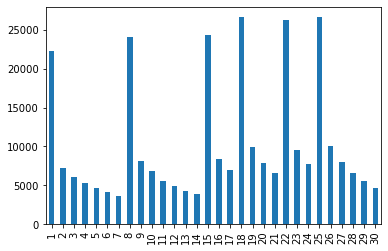

In [16]:
dfinfo['day_month'] = (dfinfo['time'] // 24) + 1
dfinfo['day_month'].value_counts().sort_index().plot.bar()

In [17]:
dfinfo.drop('time', axis= 1, inplace= True)

dfinfo.sample(10, random_state = 1)

,event,person_id,offer_id,reward_amt,purchase_amt,reward_offer,channels,difficulty,duration,offer_type,day_month
239823,no offer,1852fd4c,xxxxxx,0,2.80,NaN,NaN,NaN,NaN,NaN,24
148695,no offer,5532539d,xxxxxx,0,19.08,NaN,NaN,NaN,NaN,NaN,17
302969,offer completed,86991c80,2298d6,3,0.00,3.0,emsw,7.0,7.0,discount,30
128881,offer viewed,1929135b,4d5c57,0,0.00,10.0,emsw,10.0,5.0,bogo,15
222794,offer viewed,58566614,9b98b8,0,0.00,5.0,emw,5.0,7.0,bogo,22
103947,no offer,3723ab43,xxxxxx,0,3.44,NaN,NaN,NaN,NaN,NaN,13
5930,offer received,954b2140,2298d6,0,0.00,3.0,emsw,7.0,7.0,discount,1
119762,offer received,7aabd3e6,f19421,0,0.00,5.0,emsw,5.0,5.0,bogo,15
276603,no offer,ef8f6714,xxxxxx,0,22.43,NaN,NaN,NaN,NaN,NaN,26
95702,no offer,efef288a,xxxxxx,0,4.11,NaN,NaN,NaN,NaN,NaN,11


## Profile Data:

In [18]:
dfppl.rename(columns={'id':'person_id'}, inplace= True)
dfppl.sample(10, random_state = 0)

,gender,age,person_id,became_member_on,income
3873,F,35,b743f13d,20160430,34000.0
3625,F,35,a9ef494d,20151018,45000.0
3028,M,42,d8f12189,20180705,56000.0
13814,None,118,9da33731,20141111,NaN
15398,M,39,646797fb,20170328,61000.0
13244,M,54,e068cefa,20170721,63000.0
2516,F,76,84a64f55,20171224,57000.0
3008,O,49,6db6c774,20171122,80000.0
2619,M,70,759c2269,20170517,113000.0
2525,F,73,e928e078,20171226,49000.0


In [19]:
dfppl.dtypes

gender               object
age                   int64
person_id            object
became_member_on      int64
income              float64
dtype: object

In [20]:
## Let's clean the date column `became_member_on`
dfppl['became_member_on'] = dfppl['became_member_on'].astype(str)

dfppl['member_since'] = pd.to_datetime(dfppl['became_member_on'])
dfppl['member_year'] = dfppl['member_since'].dt.year
dfppl['member_month'] = dfppl['member_since'].dt.month

dfppl.sample(10, random_state = 0)

,gender,age,person_id,became_member_on,income,member_since,member_year,member_month
3873,F,35,b743f13d,20160430,34000.0,2016-04-30,2016,4
3625,F,35,a9ef494d,20151018,45000.0,2015-10-18,2015,10
3028,M,42,d8f12189,20180705,56000.0,2018-07-05,2018,7
13814,None,118,9da33731,20141111,NaN,2014-11-11,2014,11
15398,M,39,646797fb,20170328,61000.0,2017-03-28,2017,3
13244,M,54,e068cefa,20170721,63000.0,2017-07-21,2017,7
2516,F,76,84a64f55,20171224,57000.0,2017-12-24,2017,12
3008,O,49,6db6c774,20171122,80000.0,2017-11-22,2017,11
2619,M,70,759c2269,20170517,113000.0,2017-05-17,2017,5
2525,F,73,e928e078,20171226,49000.0,2017-12-26,2017,12


In [21]:
# Remove `became_member_on`, since we derived all necessary info from it.
dfppl.drop('became_member_on', axis= 1, inplace= True)
dfppl.sample(2)

,gender,age,person_id,income,member_since,member_year,member_month
8188,F,64,efb39b7e,73000.0,2015-09-16,2015,9
13193,M,30,d53880e2,56000.0,2016-02-04,2016,2


In [22]:
# Save the intermediate data for later usage:
dfpromo.to_pickle('../data_intermediate/portfolio.pkl')
dfppl.to_pickle('../data_intermediate/profile.pkl')
dfinfo.to_pickle('../data_intermediate/transactions.pkl')